# Frequency tracking
This example shows how to use a Kalman filter to estimate the frequencies
present in a signal.
## Definition of some constants

In [1]:
%matplotlib inline

In [1]:
import numpy as np


fs = 20
dt = 1.0 / fs
f1 = 3
f2 = 10
tau = 12

ZeroDivisionError: division by zero

## Generation of a chirp
We use `blocksim.dsp.DSPSignal.DSPSignal.fromLinearFM`

In [ ]:
from blocksim.dsp.DSPSignal import DSPSignal

chirp = DSPSignal.fromLinearFM(
    "sig", samplingStart=0, samplingPeriod=dt, tau=tau, fstart=f1, fend=f2
)
t = chirp.generateXSerie()
fchirp = (1 - t / tau) * f1 + t / tau * f2

[INFO] - Registered blocksim.loggers.CSVLogger
[INFO] - Registered blocksim.loggers.PickleLogger
[INFO] - Registered blocksim.loggers.XlsLogger


## Generation of a jammer

After tau/2, the jammer emits a pure sinusoid at frequency f2. So this is a special case of a chirp with zero bandwith

In [ ]:
jammer = DSPSignal.fromLinearFM(
    "jam", samplingStart=tau / 2, samplingPeriod=dt, tau=tau / 2, fstart=f2, fend=f2
)

## Final signal
The test signal is the superposition of the chirp and the jammer, with extra margins, and with some noise added

In [ ]:
sig = (
    (chirp + jammer)
    .resample(
        samplingStart=t[0] - 1,
        samplingPeriod=dt,
        samplingStop=t[-1] + 1,
        zero_padding=True,
    )
    .applyGaussianNoise(0.5)
)

## Frequency Estimator
We configure the frequency estimator `blocksim.control.Estimator.KalmanSpectrumEstimator`

In [ ]:
from blocksim.control.Estimator import KalmanSpectrumEstimator

tracks = np.arange(0, 20, 0.5) / fs
nb_tracks = len(tracks)

X = np.zeros(nb_tracks, dtype=np.complex128)
kal = KalmanSpectrumEstimator(
    name="kal",
    dt=dt,
    sname_output="x_kal",
    snames_state=["x_%i_est" % i for i in range(nb_tracks)],
    tracks=tracks * fs,
)
kal.matQ = np.eye(nb_tracks) / 10
kal.matR = np.eye(1) / 10
kal.setInitialStateForOutput(X, "state")

## Simulation

In [ ]:
from blocksim.Simulation import Simulation

sim = Simulation()

sim.addComputer(sig)
sim.addComputer(kal)

sim.connect("sig.setpoint", "kal.measurement")

sim.simulate(sig.generateXSerie(), progress_bar=False)

## Plotting
We plot the map, which is computed by `blocksim.control.Estimator.KalmanSpectrumEstimator.getSpectrogram`. The map is an instance of `blocksim.dsp.DSPMap.DSPRectilinearMap`. It has a method plot which allows to visualize the map

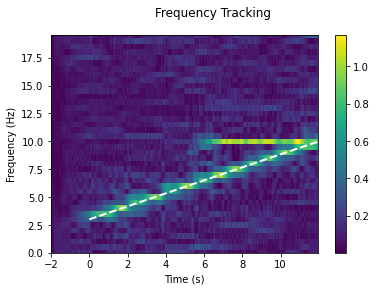

In [ ]:
log = sim.getLogger()
spg = kal.getSpectrogram(log)

from blocksim.graphics.BFigure import FigureFactory

fig = FigureFactory.create(title="Frequency Tracking")
gs = fig.add_gridspec(1, 1)
axe = fig.add_baxe(title="", spec=gs[0, 0])
axe.plot(plottable=spg)
axe.plot(
    plottable=(t, fchirp),
    linewidth=2,
    color="white",
    linestyle="--",
)
# axe.set_xlabel("Time (s)")
# axe.set_ylabel("Frequency (Hz)")
mfig = fig.render()